In [1]:
%matplotlib inline
import sys,os
p = os.path.abspath("../src")
if(not p in sys.path):
    sys.path.append(p)
from scipy.cluster.vq import kmeans,whiten
import torch
import torchvision
import torchvision.transforms as transforms
from hebbian import HebbianLayer
from whiten import compute_zca_whitening
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
transform = transforms.Compose(
    [transforms.ToTensor()])
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [2]:
def plot_images(images,show=True,subplots=(15,15)):
    
    s1,s2 = subplots
    # plt.axis('off')
    fig, axes = plt.subplots(s1,s2,sharex=True,sharey=True)
    for k,im in enumerate(images):
        i,j = k // s1, k % s2
        ax = axes[i,j]
        ax.set_axis_off()
        data = im if not isinstance(im,Variable) else im.data
        data = data if not isinstance(data,torch.Tensor) else data.squeeze().numpy()
        
        if(len(data.shape) == 2):
            ax.matshow(data)#.reshape(7,7))
        else:
            #data = (data  - np.min(data,axis=(1,2),keepdims=True))/np.max(data,axis=(1,2),keepdims=True)
            data = data/2.0 + 0.5
            data = np.transpose(data,(1,2,0))#[:,:,::-1]
            #print(data.shape)
            ax.imshow(data)
    for k in range(k,s1*s2):
        i,j = k // s1, k % s2
        axes[i,j].set_axis_off()
            # fig.colorbar(im, ax=ax)
    if(show):plt.show()

In [3]:
def compute_zca_whitening(X,epsilon=1.e-5):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [N x M] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    X = np.transpose(X)
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    # epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

In [4]:
def FOV(tensor):
    return Variable(tensor,requires_grad=False,volatile=True)
# Getting the data
batch_size = 400
assert batch_size < 500

trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [6]:
def get_whiten_matrix(path):
    import h5py
    try:
        f = h5py.File(path)
        out = f["ZCA"][:]
    except Exception as e:
        raise RuntimeError("No ZCA Matrix at %s" % path)
    f.close()
    return out
whitenMatrix = get_whiten_matrix("../src/cifar/cifar_7x7.h5")
invWhite = np.linalg.inv(whitenMatrix)
net = net = HebbianLayer(3,center=True,normalize=False,whiten="../src/cifar/cifar_7x7.h5")
print(whitenMatrix.shape)

Variable containing:
 2.9333e+00 -1.4958e-01 -7.9551e-02  ...   2.3081e-02  2.2325e-02  2.0596e-02
-1.4958e-01  2.9739e+00 -1.3136e-01  ...   2.3700e-02  2.3135e-02  2.1979e-02
-7.9551e-02 -1.3136e-01  2.9822e+00  ...   2.4128e-02  2.3616e-02  2.2691e-02
                ...                   ⋱                   ...                
 2.3081e-02  2.3700e-02  2.4128e-02  ...   2.9898e+00 -1.2638e-01 -7.7945e-02
 2.2325e-02  2.3135e-02  2.3616e-02  ...  -1.2638e-01  2.9817e+00 -1.4395e-01
 2.0596e-02  2.1979e-02  2.2691e-02  ...  -7.7945e-02 -1.4395e-01  2.9430e+00
[torch.FloatTensor of size 147x147]

(147, 147)


In [7]:
n_samples = 5000
for X,y in trainloader:
#    fetch_mldata("natural scenes data")
    X = FOV(X)
    #plot_images(X,subplots=(2,2))
    patches = net.get_patches(X).permute(0,2,3,1)
    patches.contiguous()
    patches = patches.view(-1,147).data.numpy()#.permute(1,0)
    rand_ints = np.random.choice(np.arange(len(patches)),n_samples,replace=False)
    patches = patches[rand_ints]
    #patches.contiguous()
    print(patches.shape)
    #plot_images(patches.reshape(-1,3,7,7))
    #patches = patches-np.mean(patches,axis=1,keepdims=True)
    #patches = patches/(np.std(patches,axis=1,keepdims=True)+1e-5)
    #whitenMatrix = compute_zca_whitening(patches,epsilon=1e-1)
    #invWhite = np.linalg.inv(whitenMatrix)
    #
    #patches = np.dot(whitenMatrix,patches.transpose()).transpose()
    #print(patches)
    #patches = np.dot(patches,whitenMatrix)
    #print(patches)
    #plot_images(patches.reshape(-1,3,7,7))
    #np_patches = patches
    
    means,_ = kmeans(patches,100,iter=20)
    print(means.shape)
    #print(patches.size())
    print(X.size())
    break;
    

('PATCHES', torch.Size([400, 147, 26, 26]))
(5000, 147)
(100, 147)
torch.Size([400, 3, 32, 32])


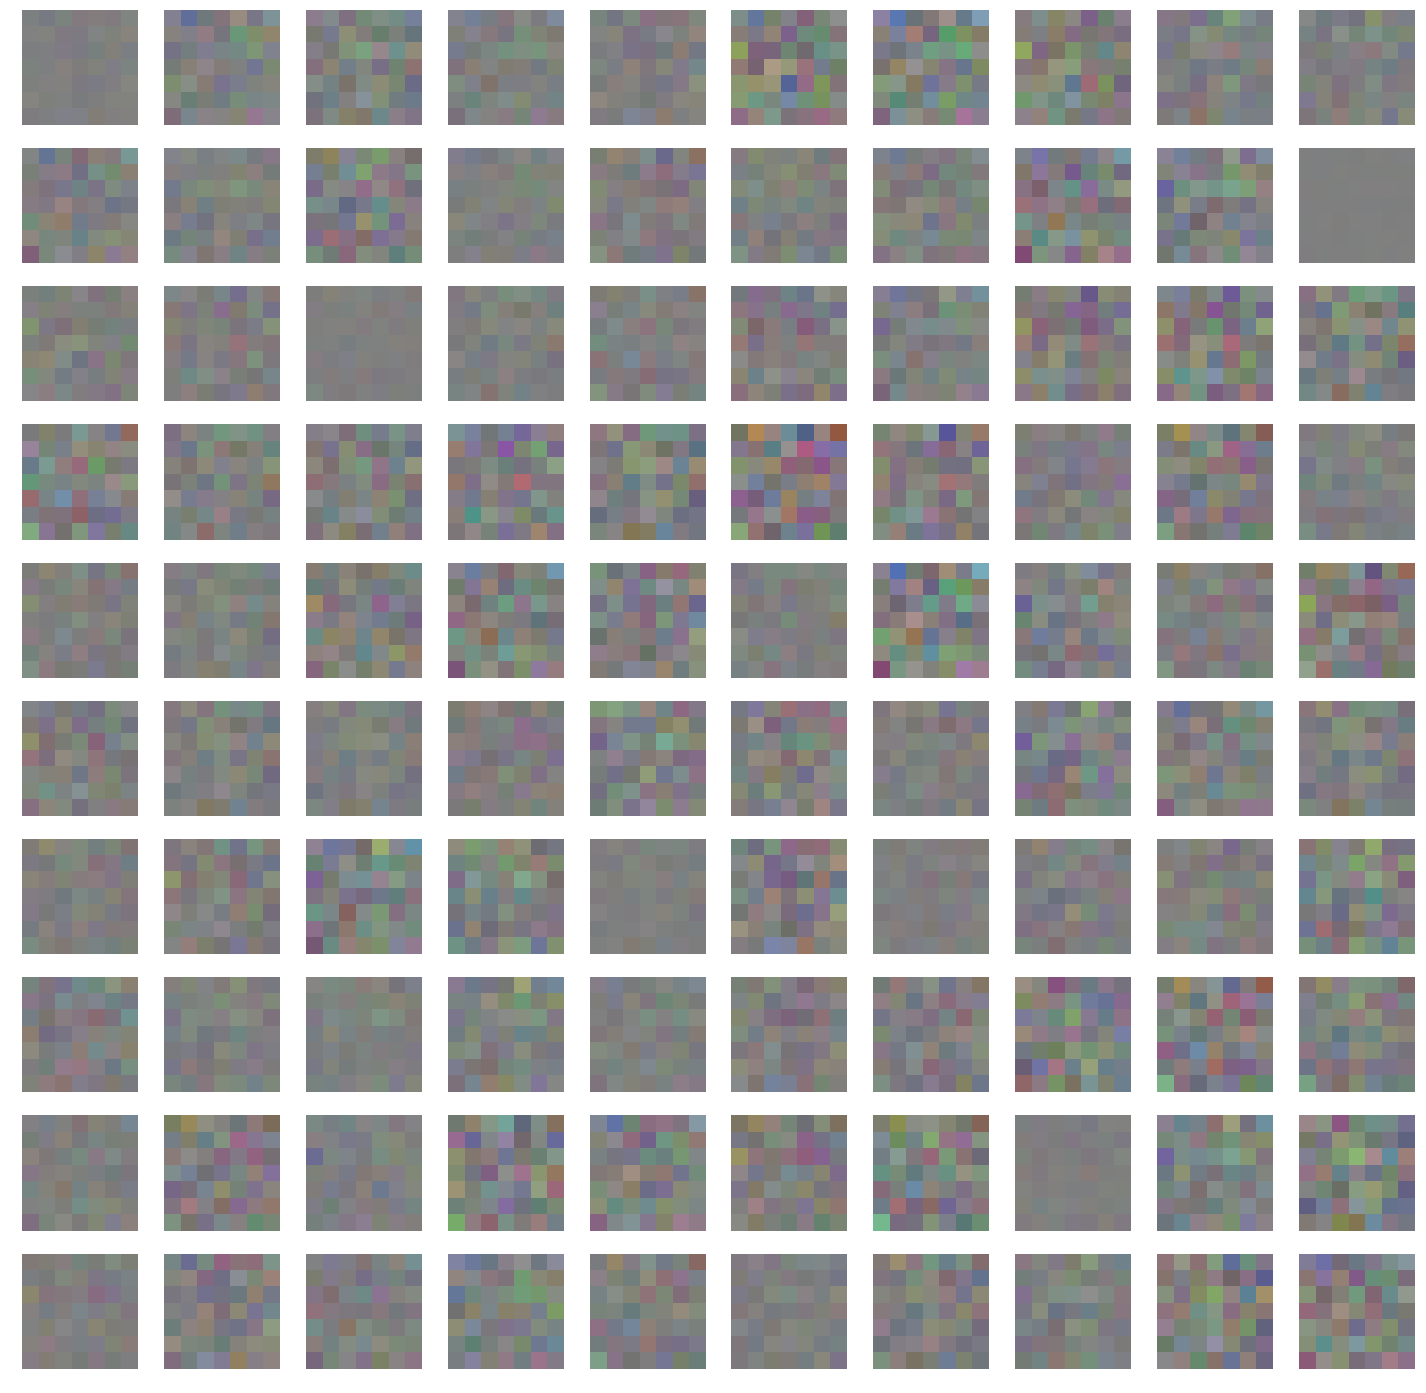

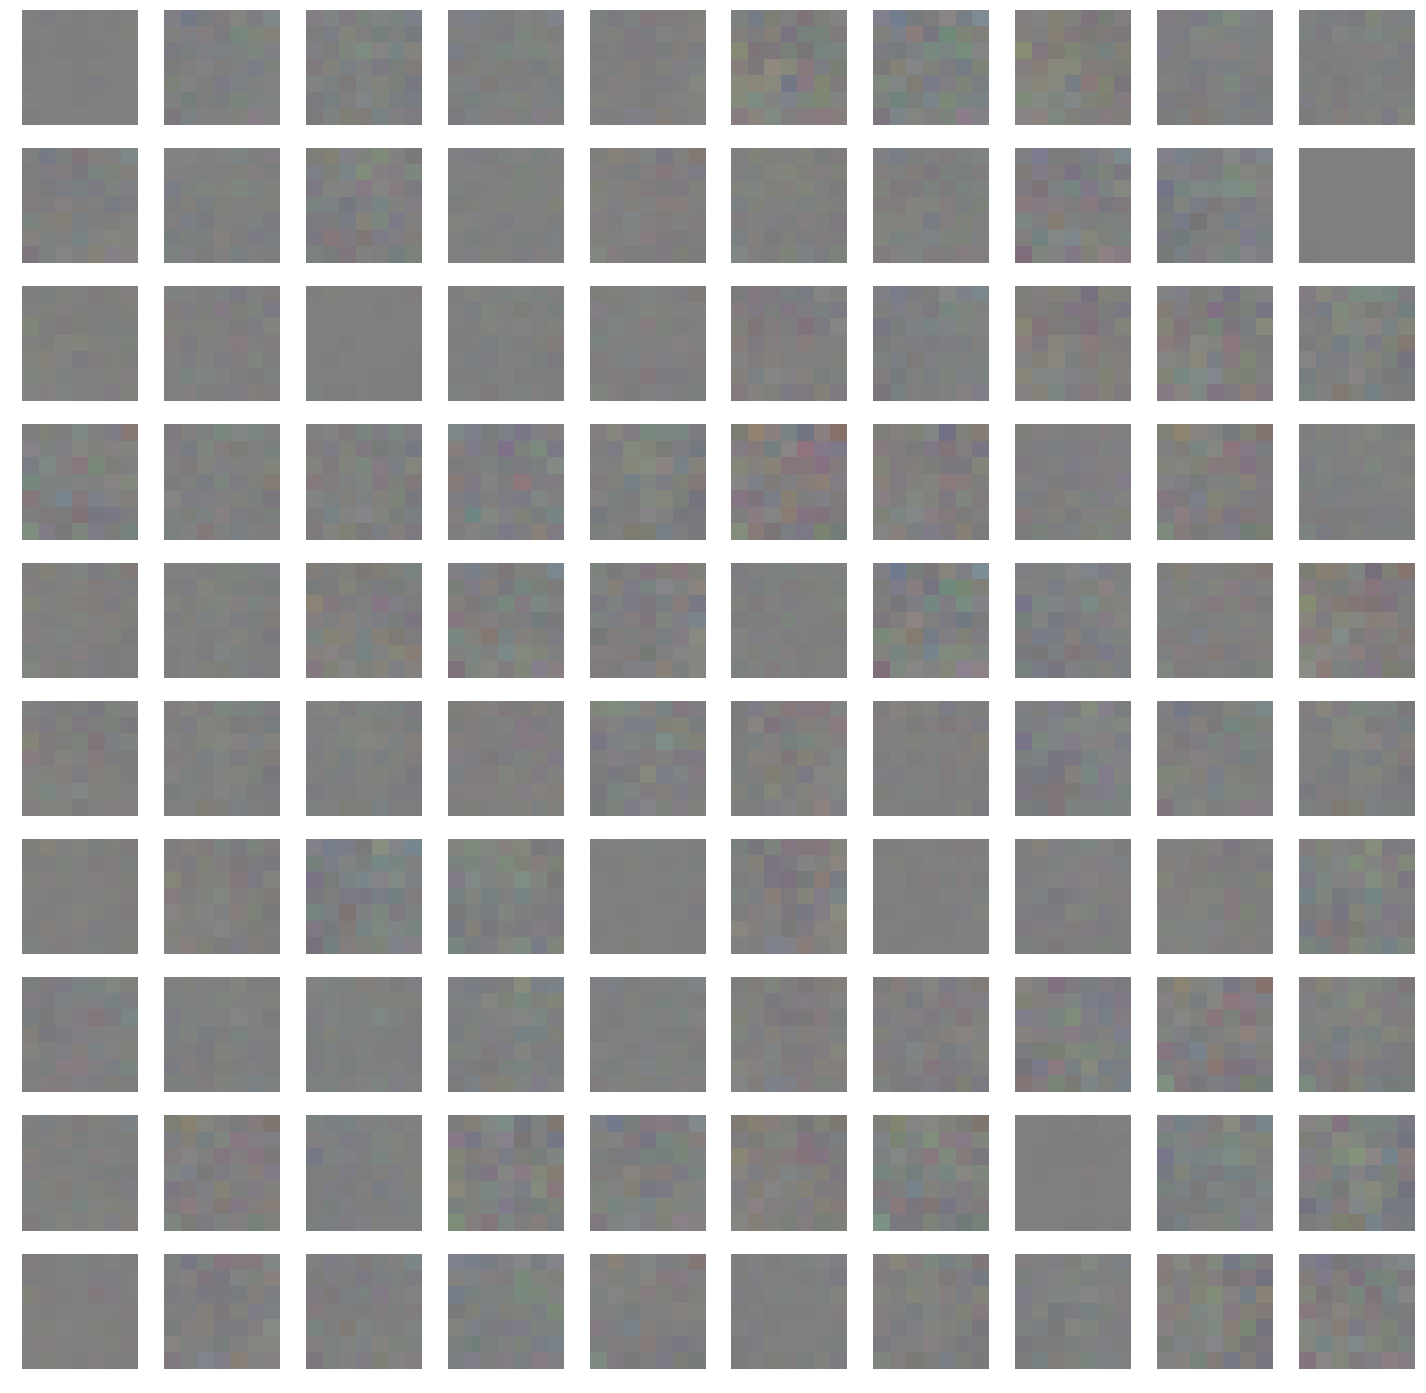

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 25, 25
plot_images(means.reshape(-1,3,7,7),subplots=(10,10))
plot_images(np.dot(invWhite,means.transpose()).transpose().reshape(-1,3,7,7),subplots=(10,10))

In [ ]:
print(means[0])